In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

#### Preliminary Data Explore

In [2]:
train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")

In [3]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [5]:
df = train.drop('id', axis=1);
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [6]:
df.dtypes

no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                         int64
required_car_parking_space                int64
room_type_reserved                        int64
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                       int64
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                            int64
dtype: object

In [7]:
df.shape

(42100, 18)

In [34]:
print ("total null values : ", df.isna().sum().sum())  # No null values

total null values :  0


In [32]:
print ("Total duplicate rows :", df.drop_duplicates().shape[0] - df.shape[0])

Total duplicate rows : 0


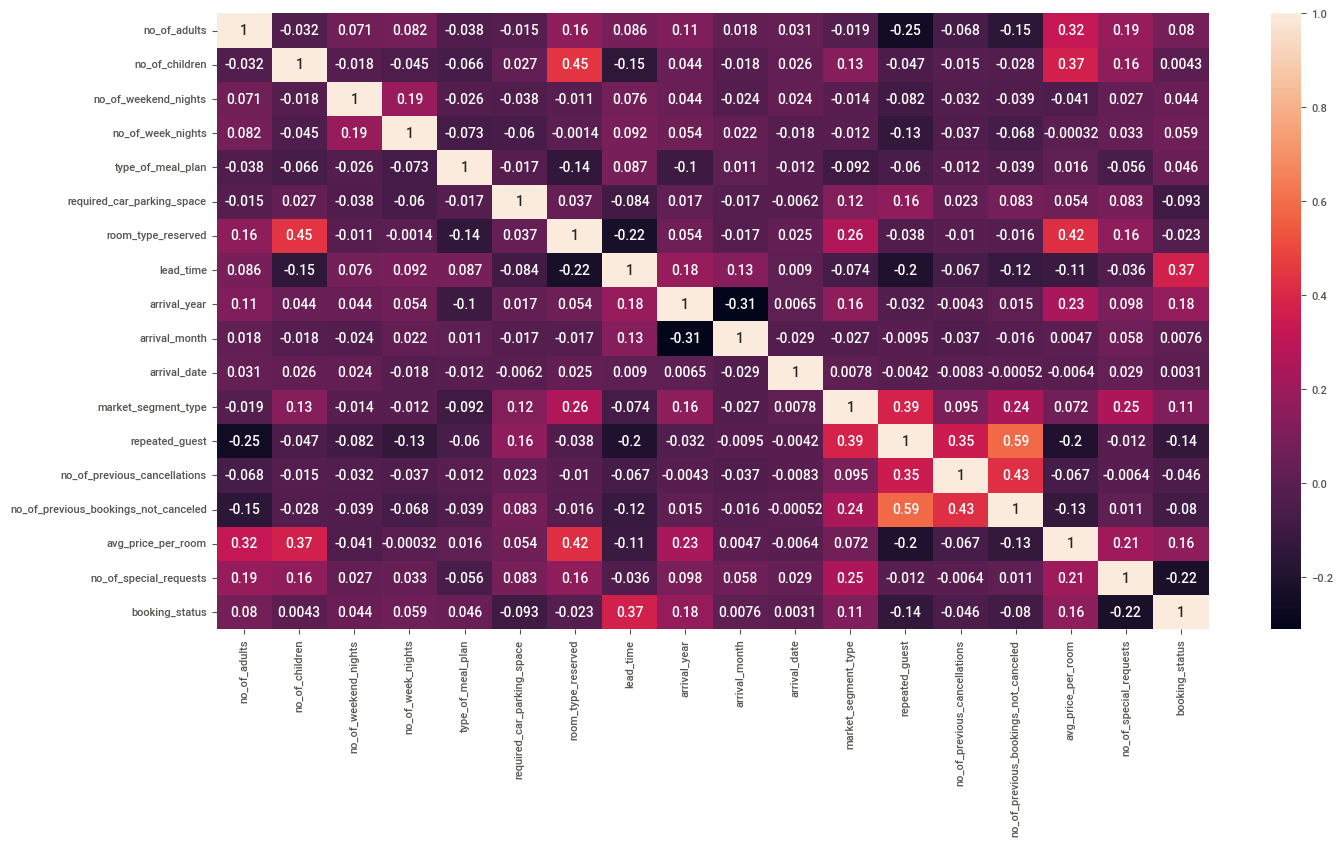

In [39]:
plt.figure(figsize=(16,8))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True);


Some correlations but not problematic (around 0.5) between no_of_previous_booking_not_canceled , no_of_previous_booking_cancellations and repeated_guess. Makes sense, when a customer recurrent use a hotel (for instance for business purpose) probably have more booking without cancellation in that hotel, and also can eventually cancel the booking. The 3 variables will be maintained as they provide important information to the model. 

In [20]:
# ! pip install sweetviz # run this just if not installed

In [15]:
import sweetviz as sv

/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Let use sweetviz tool to explore the data

my_report = sv.analyze(df)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: no_of_adults                        |███▋                                                                  | [  5%]   00:00 -> (00:00 left)/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Featur

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [17]:
# Features strategy: 

categorical = [
    'no_of_adults', # One hot encoding
    'no_of_children',  # One hot encoding
    'no_of_week_nights',  # One hot encoding, maybe new variable no_of_nights
    'no_of_weekend_nights',  # One hot encoding
    'type_of_meal_plan',  # One hot encoding
    'required_car_parking_space',# Binary, no need of One hot encoding
    'room_type_reserved', # One hot enconding
    'market_segment_type', # One hot encoding
    'repeated_guest', # Binary, no need of One hot encoding
    'no_of_special_requests',  # One hot encoding
    
]
numerical = [
    'avg_price_per_room', 
    'lead_time', # Number of days between the date of booking and the arrival date
    'no_of_previous_cancellations', 
    'no_of_previous_bookings_not_canceled'
]

seasonal = [
    'arrival_date', # Crate a seasonal sinuoidal feature mixing date (day of the month) ,  month
    'arrival_month',# covered above 
    'arrival_year', # covered above, (check also 
]
target = ['booking_status']

#### Day of the year feature

In [18]:
## Finding day of year
from datetime import datetime, date

In [115]:

# Specific date
day_of_year = date(2007, 1, 22).timetuple().tm_yday
print("Day of year: ", day_of_year, "\n")

Day of year:  22 



In [52]:
day_of_year = date(df['arrival_year'][2], df['arrival_month'][2], df['arrival_date'][2]).timetuple().tm_yday
print("Day of year: ", day_of_year, "\n")

Day of year:  336 



In [ ]:
pd.to_datetime

In [121]:
bob = df.loc[0:20,:]
bob.apply(lambda x:print(x['arrival_date'], "-->", int(x['arrival_date'])), axis=1)

14.0 --> 14
29.0 --> 29
2.0 --> 2
1.0 --> 1
16.0 --> 16
6.0 --> 6
18.0 --> 18
24.0 --> 24
8.0 --> 8
22.0 --> 22
27.0 --> 27
12.0 --> 12
30.0 --> 30
22.0 --> 22
30.0 --> 30
22.0 --> 22
2.0 --> 2
26.0 --> 26
3.0 --> 3
25.0 --> 25
28.0 --> 28


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
dtype: object

In [131]:
df['arrival_date'].unique()

array([14, 29,  2,  1, 16,  6, 18, 24,  8, 22, 27, 12, 30, 26,  3, 25, 28,
       21,  4, 11, 15, 20,  5, 10,  7, 19,  9, 23, 31, 17, 13])

In [108]:
df['day_of_the_year'] = df.apply(lambda x: date(int(x['arrival_year']), int(x['arrival_month']), int(x['arrival_date'])).timetuple().tm_yday, axis=1)

ValueError: day is out of range for month

In [112]:
df['arrival_month'].dtype

dtype('int64')

In [103]:
bob.abs

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,day_of_the_year
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,14
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,210
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,336
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,335
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2,0,2,5,2,0,0,87,2018,6,26,0,0,0,0,106.25,2,0,177
997,3,0,0,1,0,1,1,45,2018,6,8,1,0,0,0,146.70,1,0,159
998,2,0,2,4,0,0,0,228,2018,8,27,1,0,0,0,90.95,0,1,239
999,3,0,0,2,0,0,1,0,2018,6,2,1,0,0,0,157.00,2,0,153


In [85]:
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,day_of_the_year
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,14.0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,210.0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,336.0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,335.0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2,1,NaN
42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0,0,NaN
42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0,0,NaN
42098,1,0,0,3,0,0,0,5,2018,11,9,0,0,0,0,120.00,0,0,NaN


In [63]:
#df['day_of_the_year'] = df.apply(lambda x: date(df['arrival_year'], df['arrival_month'], df['arrival_date']).timetuple().tm_yday, axis=1)
#df['day_of_the_year'] = date(df['arrival_year'], df['arrival_month'], df['arrival_date']).timetuple().tm_yday
df['day_of_the_year'] = df.apply(lambda x: date(x['arrival_year'], x['arrival_month'], x['arrival_date']).timetuple().tm_yday, axis=1)
#df['day_of_the_year'] = df.apply(lambda x: x['arrival_year']- x['arrival_month'], axis=1)
df

TypeError: integer argument expected, got float

#### Relation betweet target and features

# ToDo 
* create seasonal feature
* E.D.A see how each feature affect the target, including seasonal feature (to check if there is a seasonality)
* ML basic
* ML with feature engineenring